# Imports


In [ ]:
!pip install -r requirements.txt
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import random
import glob
import seaborn as sns
from inference.py import *
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.losses import JaccardLoss
from segmentation_models_pytorch.utils.metrics import IoU
import warnings
import networkx as nx
import os
from sklearn.metrics import precision_score, recall_score, f1_score
warnings.filterwarnings("ignore")
import pandas as pd
pl.seed_everything(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import rasterio
from aeronet_vector import FeatureCollection, Feature
import shapely
import numpy as np
from matplotlib import pyplot as plt
import os
from dlutils.data import markup_generation, fcutils, angleutils, heightutils, markup_generation
from dlutils.utils import visualization, npfile_utils
import cv2 
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from pathlib import Path

In [ ]:
from inference.py import *
from stability_metrics.py import *

# Inference model

In [ ]:
mean = [0.253317  , 0.26740879, 0.23025433]
std  = [0.15158384, 0.14880167, 0.14123519]

train_augs = A.Compose([
    # A.Flip(p=0.5),
    # A.Rotate(border_mode=0, p=0.8),
    # A.RandomScale(scale_limit=0.2, p=0.5),
    A.RandomBrightness(limit=0.2, p=0.2),
    A.RandomContrast(limit=0.2, p=0.2),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.2),
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0, always_apply=True),
    A.PadIfNeeded(512,512, border_mode=0),    
    A.CenterCrop(512,512, always_apply=True),
    ToTensorV2()
])

val_augs = A.Compose([
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
])

test_augs = A.Compose([
    # A.Flip(p=0.5),
    # A.Rotate(border_mode=0, p=0.5),
    # A.RandomScale(scale_limit=0.2, p=0.5),
    A.RandomBrightness(limit=0.1, p=0.3),
    A.RandomContrast(limit=0.1, p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0, always_apply=True),
    A.PadIfNeeded(512,512, border_mode=0),    
    A.CenterCrop(512,512, always_apply=True),
    ToTensorV2()
])

model_name = 'unet34_30_8_0_0.0001_w_color_augs'
#  model_name = 'unet34_20_8_0_5e-05_w_color_augs'
model = ModelPl.load_from_checkpoint('unet_resnet34/'+ model_name +'.ckpt')
Predictor = SimplePredictor(model.cuda(), device=device, 
                            sample_size=(512,512), 
                            #sample_size=(1024,1024), 
                            pad_size=64)
scores = calculate_metrics(Predictor, 'E:/diplom_dataset/samples_cheater/test', 
                           augs=val_augs, 
                           threshold=0.5)

df = pd.DataFrame(pd.DataFrame(scores))
print(df)
df.to_csv('metrics/files/orig_img_'+ model_name +'.csv', index=False) 

### show picture with augs

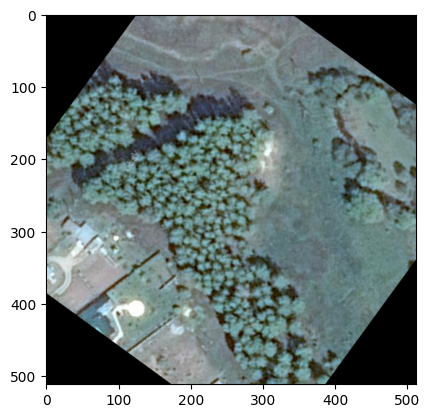

In [239]:
test_augs = A.Compose([
    #A.Flip(p=0.8),
    A.Rotate(border_mode=0, p=0.8),
    A.RandomScale(scale_limit=0.2, p=0.5),
    # A.RandomBrightness(limit=0.1, p=0.8),
    # A.RandomContrast(limit=0.1, p=0.8),
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.8),
    # A.Normalize(mean=mean, std=std, max_pixel_value=255.0, always_apply=True),
    A.PadIfNeeded(512,512, border_mode=0),    
    A.CenterCrop(512,512, always_apply=True),
    ToTensorV2()
])

img = np.array(Image.open('samples_new\\test\images\\53_201.tif'))
mask = np.array(Image.open('samples_new\\test\masks\\53_201.tif'))
after_augs = test_augs(image=img,mask=mask)
plt.imshow(after_augs['image'].T)

### show result of the model

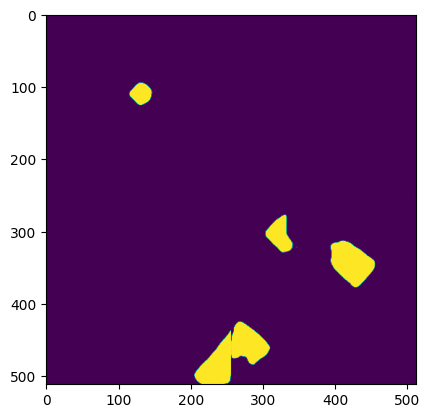

In [18]:
num = '01_345'
model = ModelPl.load_from_checkpoint('unet_resnet34/unet34_20_8_0_5e-05.ckpt').cuda()

Predictor = SimplePredictor(model.cuda(), device=device, sample_size=(512,512), pad_size=64)
img = cv2.imread('E:/diplom_dataset/samples_cheater/test/images/'+str(num)+'.tif')
img_t = val_augs(image=img)['image']
pred = Predictor(img_t)
plt.imshow(pred)